## Summary of notebook:

This notebook provides a brief introduction of the open-source dataset to be used in subsequent notebooks. In particular, SNR20 is used in this notebook.

Distribution of the labels and sample fingerprints for different user equipments at different reference points are explored. 

In [11]:
# Configure amd test GPU
import tensorflow as tf
from tensorflow.python.client import device_lib

# Prevent automatic GPU memory pre-allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

print(tf.__version__)
# print(device_lib.list_local_devices())

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.9.1


## EDA on data

- Boxplot for ranges of x,y and z values
- Generate heatmap images for the same RP, from the different UEs and observe similarity
- Generate heatmap images for different RPs, from the same UEs and observe similarity

Note: Metrics used for similarity would be Structural Similarity Index Measure (SSIM).

In [12]:
import os

print(os.getcwd())
os.chdir('../datasets')
print(os.getcwd())

/home/jovyan/committed_git/datasets
/home/jovyan/committed_git/datasets


In [23]:
# may delete later
# New way to import the data
import h5py
import numpy as np
import tensorflow as tf

# Open HDF5 file and access the dataset
filename = 'dataset_SNR20_outdoor.mat'
hdf5_file = h5py.File(filename, 'r')

features_dataset = hdf5_file['features']
labels_dataset = hdf5_file['labels']['position']

# Convert HDF5 dataset to NumPy array
features = np.array(features_dataset)
labels = np.array(labels_dataset)

print(features.shape)
print(labels.shape)

def flatten_dataset(ds):
  
    prev_shape = ds.shape
    ds = ds.reshape(prev_shape[0]*prev_shape[1], prev_shape[2], prev_shape[3])
    print(f'Reformatted shape is {ds.shape}')
    return ds

features = flatten_dataset(features)

count = 0
rp_dict = {}
# For labels, have a shape of (1,) where that number represents the class of that coordinate

for label in labels:
    rp_dict[count] = label
    count += 1

labels = np.array([i for i in range(3876)])
labels = np.repeat(labels,4, axis=0)
# labels = tf.one_hot(labels, 3876)

# Close the HDF5 file
hdf5_file.close()

# Currently, for features, have features from 3876 reference points, from 4 UEs, for (16,193) matrices
# Would want to flatten the 4D np features array to a 3D np features array where (3876,4,16,193) --> (3876*4,16,193)
print(features.shape)
print(labels.shape)

dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.map(lambda x,y : (x, tf.expand_dims(y, axis = 0)))

print(dataset)

(3876, 4, 16, 193)
(3876, 3)
Reformatted shape is (15504, 16, 193)
(15504, 16, 193)
(15504,)
<MapDataset element_spec=(TensorSpec(shape=(16, 193), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


<Figure size 3600x3600 with 0 Axes>

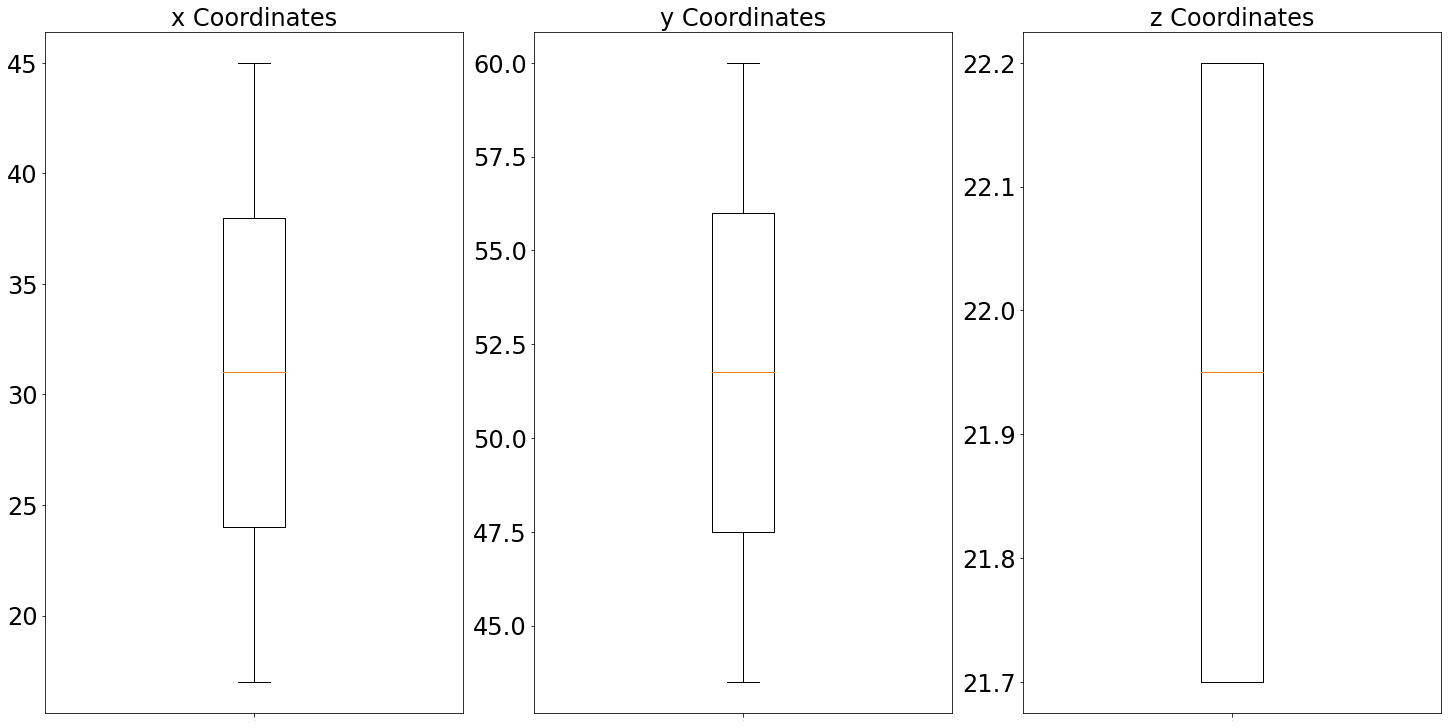

<Figure size 3600x3600 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(1,3, constrained_layout = True)

# Get the distribution for x, y and z coordinates
coords = list(rp_dict.values())
coords = np.array(coords)

x_coords = coords[:,0]
y_coords = coords[:,1]
z_coords = coords[:,2]

axs[0].set_title('x Coordinates', fontsize = 24)
axs[0].yaxis.set_tick_params(labelsize = 24)
axs[0].xaxis.set_tick_params(labelsize = 0)
axs[0].boxplot(x_coords)

axs[1].set_title('y Coordinates', fontsize = 24)
axs[1].yaxis.set_tick_params(labelsize = 24)
axs[1].xaxis.set_tick_params(labelsize = 0)
axs[1].boxplot(y_coords)

axs[2].set_title('z Coordinates', fontsize = 24)
axs[2].yaxis.set_tick_params(labelsize = 24)
axs[2].xaxis.set_tick_params(labelsize = 0)
axs[2].boxplot(z_coords)

plt.figure(figsize = (50,50))

In [25]:
x_coords_np = np.array(x_coords)
x_q3, x_q1 = np.percentile(x_coords_np, [75,25])
x_iqr = x_q3 - x_q1
print(f'X interquartile range: {x_iqr}')

y_coords_np = np.array(y_coords)
y_q3, y_q1 = np.percentile(y_coords_np, [75,25])
y_iqr = y_q3 - y_q1
print(f'y interquartile range: {y_iqr}')

z_coords_np = np.array(z_coords)
z_q3, z_q1 = np.percentile(z_coords_np, [75,25])
z_iqr = z_q3 - z_q1
print(f'z interquartile range: {z_iqr}')

X interquartile range: 14.0
y interquartile range: 8.5
z interquartile range: 0.5


In [26]:
# Function to generate heatmaps, not the same as function below used to get heatmap pixel values from heatmap
def get_features(feature):
        
    for f, l in feature:
        
        f = f.numpy()
        f = f.T

        return f

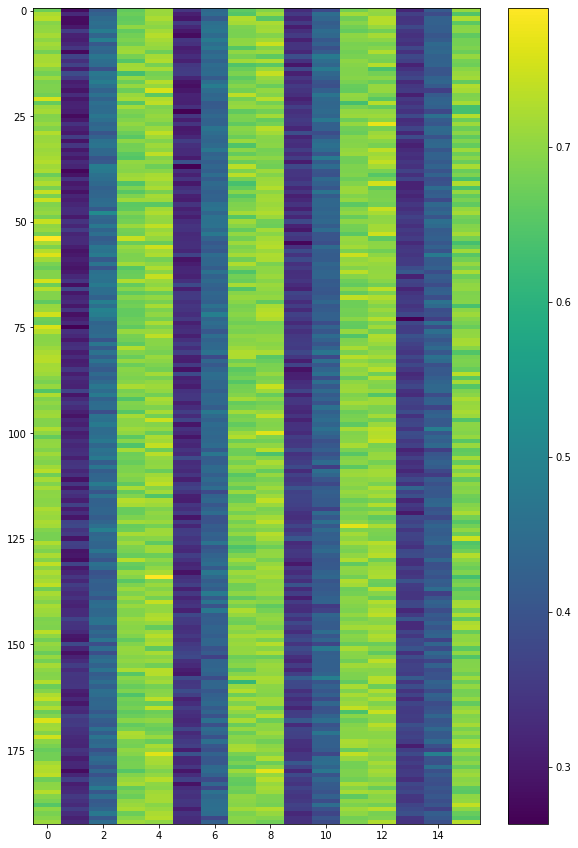

In [27]:
plt.rcParams['figure.figsize'] = [10, 15]

feature_1 = get_features(dataset.take(1))

plt.colorbar(plt.imshow(feature_1))
plt.imshow(feature_1, aspect = 'auto')

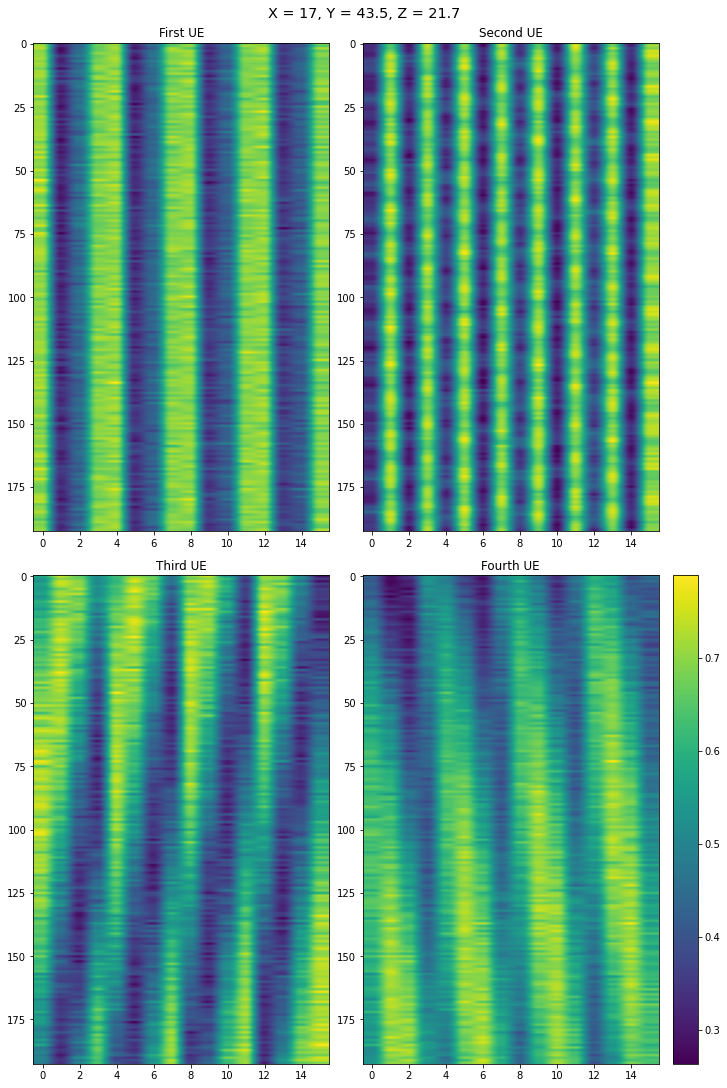

In [30]:
# Part 1 - Generate heatmap images for the same RP, from the different UEs and observe similarity
# Let's take the heatmap images from the four UEs, from the first reference point (17. , 43.5 , 21.7)

feature_1 = get_features(dataset.take(1))
feature_2 = get_features(dataset.skip(1).take(1))
feature_3 = get_features(dataset.skip(2).take(1))
feature_4 = get_features(dataset.skip(3).take(1))

fig, axs = plt.subplots(2,2, constrained_layout = True)

# Overall title
fig.suptitle("X = 17, Y = 43.5, Z = 21.7", fontsize="x-large")

plt.colorbar(plt.imshow(feature_1))
axs[0,0].imshow(feature_1, aspect = 'auto')
axs[0,0].title.set_text("First UE")
axs[0,1].imshow(feature_2, aspect = 'auto')
axs[0,1].title.set_text("Second UE")
axs[1,0].imshow(feature_3, aspect = 'auto')
axs[1,0].title.set_text("Third UE")
axs[1,1].imshow(feature_4, aspect = 'auto')
axs[1,1].title.set_text("Fourth UE")

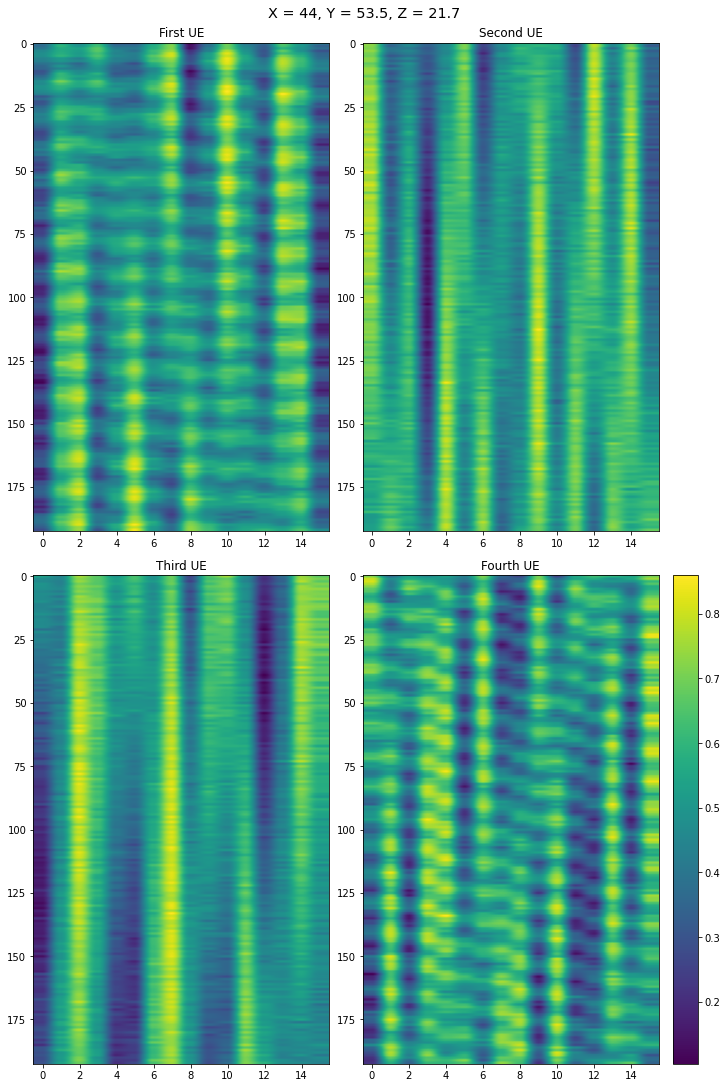

In [31]:
feature_1 = get_features(dataset.skip(7423).take(1))
feature_2 = get_features(dataset.skip(7424).take(1))
feature_3 = get_features(dataset.skip(7425).take(1))
feature_4 = get_features(dataset.skip(7426).take(1))

fig, axs = plt.subplots(2,2, constrained_layout = True)

# Overall title
fig.suptitle("X = 44, Y = 53.5, Z = 21.7", fontsize="x-large")

plt.colorbar(plt.imshow(feature_1))
axs[0,0].imshow(feature_1, aspect = 'auto')
axs[0,0].title.set_text("First UE")
axs[0,1].imshow(feature_2, aspect = 'auto')
axs[0,1].title.set_text("Second UE")
axs[1,0].imshow(feature_3, aspect = 'auto')
axs[1,0].title.set_text("Third UE")
axs[1,1].imshow(feature_4, aspect = 'auto')
axs[1,1].title.set_text("Fourth UE")

- Observation: For similar coordinates, heatmaps are distinctively different.
- Conclusion: Fingerprints obtained from the different UEs should not be treated as inputs for the same coordinates.2907

Moving forward, let's use the SSIM metrics to determine how different the images are where value of 1 implies that images are similar/same while value of -1 implies that images are very different.

In [32]:
# Lets compare heatmap from first UE to the other UE's heatmap images
def ssim_generate_heatmap(feature):

    im = plt.imshow(feature)
    plt.close() # for preventing heatmap from showing
    plt.clf() # clear current figure when done

    colour_vals_rgba = im.cmap(im.norm(im.get_array()))
    return tf.convert_to_tensor(colour_vals_rgba)

img1 = ssim_generate_heatmap(feature_1)
img2 = ssim_generate_heatmap(feature_2)
img3 = ssim_generate_heatmap(feature_3)
img4 = ssim_generate_heatmap(feature_4)

imgs = [img1, img2, img3, img4]
res = [[0]*4 for i in range(4)]

for i in range(4):
    for j in range(4-i):
        res[i][j] = tf.image.ssim(imgs[i], imgs[j], max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03).numpy()

print(res)

[[1.0, 0.084524035, 0.3522838, 0.23416074], [0.084524035, 1.0, 0.1779906, 0], [0.3522838, 0.1779906, 0, 0], [0.23416074, 0, 0, 0]]


<Figure size 720x1080 with 0 Axes>

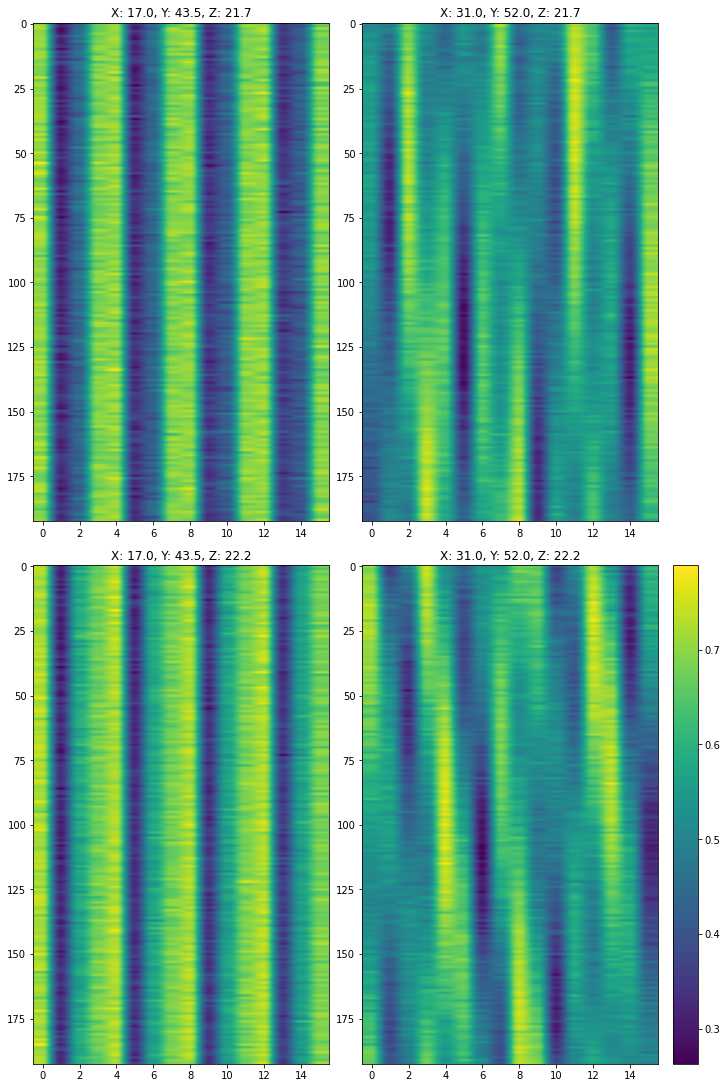

In [33]:
# Let's take the heatmap images from four different RP, each from the same UE.

# Open HDF5 file and access the dataset
filename = 'dataset_SNR20_outdoor.mat'
hdf5_file = h5py.File(filename, 'r')

features_dataset = hdf5_file['features']
labels_dataset = hdf5_file['labels']['position']

# Convert HDF5 dataset to NumPy array
features = np.array(features_dataset)
labels = np.array(labels_dataset)

# Obtain only measurements taken from the first UE
# print(features.shape)

first_ue_features = []

for i in range(len(features)):
    first_ue_features.append(features[i][0])
    
first_ue_features = np.array(first_ue_features)
# print(first_ue_features.shape)

fig, axs = plt.subplots(2,2, constrained_layout = True)

# Take reference points with index 0, 969, 1,938, 2,907

plt.colorbar(plt.imshow(first_ue_features[0].T))

axs[0,0].imshow(first_ue_features[0].T, aspect = 'auto') 
axs[0,0].title.set_text(f'X: {rp_dict[0][0]}, Y: {rp_dict[0][1]}, Z: {rp_dict[0][2]}')

axs[0,1].imshow(first_ue_features[969].T, aspect = 'auto')
axs[0,1].title.set_text(f'X: {rp_dict[969][0]}, Y: {rp_dict[969][1]}, Z: {rp_dict[969][2]}')

axs[1,0].imshow(first_ue_features[1938].T, aspect = 'auto')
axs[1,0].title.set_text(f'X: {rp_dict[1938][0]}, Y: {rp_dict[1938][1]}, Z: {rp_dict[1938][2]}')

axs[1,1].imshow(first_ue_features[2907].T, aspect = 'auto')
axs[1,1].title.set_text(f'X: {rp_dict[2907][0]}, Y: {rp_dict[2907][1]}, Z: {rp_dict[2907][2]}')

- Observation: For the same UE, heatmaps at different coordinates are distinctively different. For nearby coordinates which only differ by z-coordinate, difference is discernable enough.
- Conclusion: Fingerprints obtained at different coordinates can be used to identify coordinates.

In [34]:
# Lets compare heatmap from first UE to the other UE's heatmap images
def ssim_generate_heatmap(feature):

    im = plt.imshow(feature)
    plt.close() # for preventing heatmap from showing
    plt.clf() # clear current figure when done

    colour_vals_rgba = im.cmap(im.norm(im.get_array()))
    return tf.convert_to_tensor(colour_vals_rgba)

img1 = ssim_generate_heatmap(first_ue_features[0].T)
img2 = ssim_generate_heatmap(first_ue_features[969].T)
img3 = ssim_generate_heatmap(first_ue_features[1938].T)
img4 = ssim_generate_heatmap(first_ue_features[2907].T)

imgs = [img1, img2, img3, img4]
res = [[0]*4 for i in range(4)]

for i in range(4):
    for j in range(4-i):
        res[i][j] = tf.image.ssim(imgs[i], imgs[j], max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03).numpy()

print(res)

[[1.0, 0.46209517, 0.92599344, 0.46850348], [0.46209517, 1.0, 0.476507, 0], [0.92599344, 0.476507, 0, 0], [0.46850348, 0, 0, 0]]


<Figure size 720x1080 with 0 Axes>